In [1]:
import xarray as xr
import numpy as np
import warnings
from tqdm import tqdm, tqdm_notebook
from matplotlib import pyplot as plt
%matplotlib inline
warnings.simplefilter('ignore', xr.SerializationWarning)
xr.__version__

'0.11.3'

In [2]:
from time import sleep
for n in tqdm_notebook(range(5)):
    sleep(0.1)

In [3]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import numpy
import pandas as pd
from collections import OrderedDict

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def check_doc_for_malformed_id(d):
    source_id = d['source_id'][0]
    expt_id = d['experiment_id'][0]
    if not  f"{source_id}_{expt_id}" in d['id']:
        raise ValueError(f"Dataset id {d['id']} is malformed")
                         
def maybe_squeze_values(d):
    def _maybe_squeeze(value):
        if isinstance(value, str):
            return value
        try:
            if len(value)==1:
                return value[0]
        except TypeError:
            return(value)
    return {k: _maybe_squeeze(v) for k, v in d.items()}
                         
def get_request(client, server, verbose=False, **payload):
    url_keys = [] 
    url_keys = ["{}={}".format(k, payload[k]) for k in payload]
    url = "{}/?{}".format(server, "&".join(url_keys))
    if verbose:
        print(url)
    r = client.get(url)
    r.raise_for_status()
    resp = r.json()["response"]
    return resp

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                # this option should not be necessary with local_node=True
                filter_server_url=None,
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
                         
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    init_resp = get_request(client, server, offset=0, verbose=verbose, **payload)
    num_found = int(init_resp["numFound"])
                         
    offset = 0
    all_files = []
    files_type = files_type.upper()
         
    with tqdm_notebook(total=num_found, desc='ESGF Search', unit='docs') as pbar:
        while offset < num_found:
            resp = get_request(client, server, offset=offset, verbose=verbose, **payload)

            docs = resp["docs"]
            offset += len(docs)
            pbar.update(len(docs))

            for d in docs:
                try:
                    check_doc_for_malformed_id(d)
                except ValueError:
                    continue
                dataset_id = d['dataset_id']
                item = OrderedDict(dataset_id=dataset_id, id=d['id'])
                #item.update({field: d[field][0] for field in required_fields})
                target_urls = d.pop('url')
                item.update(maybe_squeze_values(d))
                for f in target_urls:
                    sp = f.split("|")
                    if sp[-1] == files_type:
                        opendap_url = sp[0].replace('.html', '')
                        if filter_server_url is None or filter_server_url in opendap_url:
                            item.update({f'{files_type}_url': opendap_url})
                            all_files.append(item)
        pbar.close()
    # dropping duplicates on checksum removes all identical files
    return pd.DataFrame(all_files).drop_duplicates(subset='checksum')

In [4]:
#files = esgf_search(variable="tas", experiment_id="historical", frequency="mon")
#files = esgf_search(variable="ta", frequency="mon", activity_drs='CMIP', table_id='Amon', experiment_id='historical')

# 233 files
#files = esgf_search(mip_era='CMIP6', activity_drs='CMIP', variable="ta", table_id='Amon', filter_server_url='aims3.llnl.gov')

# 1179 files
#files = esgf_search(mip_era='CMIP6', activity_drs='CMIP', variable="ta")

files = esgf_search(mip_era='CMIP6', activity_drs='CMIP', institution_id='IPSL',
                    table_id='Amon', latest='true', filter_server_url='aims3.llnl.gov')


files.head()

,dataset_id,id,version,activity_drs,activity_id,branch_method,cf_standard_name,checksum,checksum_type,citation_url,...,variable,variable_id,variable_long_name,variable_units,variant_label,_version_,retracted,_timestamp,score,OPENDAP_url
0,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,1,CMIP,CMIP,standard,air_pressure_at_convective_cloud_base,56a3e013b7f04b73da469fd52a08eefbcfb16b0fa92eb9...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,ccb,ccb,Air Pressure at Convective Cloud Base,Pa,r1i1p1f1,1625417225775087616,False,2019-02-14T04:31:01.666Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
1,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,1,CMIP,CMIP,standard,air_pressure_at_convective_cloud_top,773b27650b2fe09ff85ebfe3f84fb4db97de1cb1730d34...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,cct,cct,Air Pressure at Convective Cloud Top,Pa,r1i1p1f1,1625417226054008832,False,2019-02-14T04:31:01.932Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
2,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,1,CMIP,CMIP,standard,mole_fraction_of_cfc11_in_air,51096d60d44ea5ed67388d292e681a8c65253fa3c9c8c5...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,cfc11global,cfc11global,Global Mean Mole Fraction of CFC11,1e-12,r1i1p1f1,1625417226404233216,False,2019-02-14T04:31:02.266Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
3,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,1,CMIP,CMIP,standard,mole_fraction_of_methane_in_air,c0a1deda3a18dbaec7a8d9ef437d13d2cb5dc93d59c796...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,ch4global,ch4global,Global Mean Mole Fraction of CH4,1e-09,r1i1p1f1,1625417226694688768,False,2019-02-14T04:31:02.543Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
4,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,CMIP6.CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1....,1,CMIP,CMIP,standard,convection_time_fraction,410399bd3266ed43e89d1adc3e794d250b291800cca3d0...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,ci,ci,Fraction of Time Convection Occurs,1,r1i1p1f1,1625417226941104128,False,2019-02-14T04:31:02.777Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...


In [5]:
files.experiment_id.unique()

array(['1pctCO2', 'abrupt-4xCO2', 'amip', 'historical', 'piControl-spinup',
       'piControl'], dtype=object)

In [6]:
dataset_fields = ['institution_id', 'source_id', 'experiment_id', 'table_id', 'grid_label']
for dset_keys, dset_files in tqdm_notebook(files.groupby(dataset_fields)):
    dset_id = '.'.join(dset_keys)
    print(dset_id)
    display(dset_files.groupby(['member_id', 'variable_id']).OPENDAP_url.count())
    #for var_id, var_files in dset_files.groupby('variable_id'):
    #    print('-', var_id)
    #    for m_id, m_files in var_files.groupby('member_id'):
    #        pass
    #        print('  -', m_id, len(m_files))

IPSL.IPSL-CM6A-LR.1pctCO2.Amon.gr


member_id  variable_id
r1i1p1f1   ccb            1
           cct            1
           cfc11global    1
           ch4global      1
           ci             1
           cl             1
           cli            1
           clivi          1
           clt            1
           clw            1
           co2mass        1
           evspsbl        1
           hfls           1
           hfss           1
           hur            1
           hurs           1
           hus            1
           mc             1
           n2oglobal      1
           o3             1
           pfull          1
           phalf          1
           pr             1
           prc            1
           prsn           1
           prw            1
           ps             1
           psl            1
           rlds           1
           rldscs         1
           rlus           1
           rlut           1
           rlutcs         1
           rsdscs         1
           rsdt          

IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Amon.gr


member_id  variable_id
r1i1p1f1   ccb            1
           cct            1
           cfc11global    1
           cfc12global    1
           ch4global      1
           ci             1
           cl             1
           cli            1
           clivi          1
           clt            1
           clw            1
           clwvi          1
           co2mass        1
           evspsbl        1
           hfls           1
           hfss           1
           hur            1
           hurs           1
           hus            1
           mc             1
           n2oglobal      1
           o3             1
           pfull          1
           phalf          1
           pr             1
           prc            1
           prsn           1
           prw            1
           ps             1
           rlds           1
           rldscs         1
           rlus           1
           rlutcs         1
           rsds           1
           rsdscs        

IPSL.IPSL-CM6A-LR.amip.Amon.gr


member_id  variable_id
r10i1p1f1  ccb            1
           cct            1
           cfc11global    1
           ch4global      1
           ci             1
           cl             1
           clt            1
           clwvi          1
           hfss           1
           hur            1
           hus            1
           huss           1
           mc             1
           o3             1
           pfull          1
           phalf          1
           prc            1
           prsn           1
           ps             1
           psl            1
           rlds           1
           rldscs         1
           rlus           1
           rsdscs         1
           rsus           1
           rsuscs         1
           rsut           1
           rsutcs         1
           rtmt           1
           sfcWind        1
                         ..
r9i1p1f1   hur            1
           hurs           1
           pfull          1
           phalf         

IPSL.IPSL-CM6A-LR.historical.Amon.gr


member_id  variable_id
r10i1p1f1  ccb            1
           cct            1
           cfc11global    1
           cfc12global    1
           ch4global      1
           ci             1
           cl             1
           cli            1
           clivi          1
           clt            1
           clw            1
           clwvi          1
           co2mass        1
           evspsbl        1
           hfls           1
           hfss           1
           hur            1
           hurs           1
           hus            1
           huss           1
           mc             1
           n2oglobal      1
           o3             1
           pfull          1
           phalf          1
           pr             1
           prc            1
           prsn           1
           prw            1
           ps             1
                         ..
r5i1p1f1   ps             1
           psl            1
           rlds           1
           rldscs        

IPSL.IPSL-CM6A-LR.piControl.Amon.gr


member_id  variable_id
r1i1p1f1   ccb            3
           cct            3
           cfc11global    3
           cfc12global    3
           ch4global      3
           ci             3
           cl             3
           cli            3
           clivi          3
           clt            3
           clw            3
           clwvi          3
           co2mass        3
           evspsbl        3
           hfls           3
           hfss           3
           hur            3
           hurs           3
           hus            3
           huss           3
           mc             3
           n2oglobal      2
           o3             2
           pfull          2
           phalf          2
           pr             3
           prc            3
           prsn           3
           prw            3
           ps             3
           psl            3
           rlds           3
           rldscs         3
           rlus           3
           rlut          

IPSL.IPSL-CM6A-LR.piControl-spinup.Amon.gr


member_id  variable_id
r1i1p1f1   ccb            1
           cct            1
           cfc12global    1
           ch4global      1
           ci             1
           cl             1
           clivi          1
           clt            1
           clw            1
           clwvi          1
           co2mass        1
           evspsbl        1
           hfls           1
           hfss           1
           hur            1
           hurs           1
           hus            1
           huss           1
           mc             1
           n2oglobal      1
           o3             2
           pfull          1
           phalf          1
           pr             1
           prc            1
           prsn           1
           prw            1
           ps             1
           psl            1
           rlds           1
           rlus           1
           rlut           1
           rlutcs         1
           rsds           1
           rsdscs        

In [61]:
def set_bnds_as_coords(ds):
    new_coords_vars = [var for var in ds.data_vars if 'bnds' in var or 'bounds' in var]
    ds = ds.set_coords(new_coords_vars)
    return ds

def fix_climatology_time(ds):
    for dim in ds.dims:
        if 'climatology' in ds[dim].attrs:
            ds = ds.rename({dim: dim + '_climatology'})
    return ds

def set_coords(ds):
    # there should only be one variable per file
    # everything else is coords
    varname = ds.attrs['variable_id']
    coord_vars = set(ds.data_vars) - {varname}
    ds = ds.set_coords(coord_vars)
    ds = fix_climatology_time(ds)
    return(ds)

def concat_timesteps(urls):
    if len(urls) > 1:
        return xr.open_mfdataset(urls, concat_dim='time',
                                 chunks={'time': 'auto'},
                                 preprocess=set_coords)
    else:
        return set_coords(xr.open_dataset(urls.values[0],
                                          chunks={'time': 'auto'}))

def concat_ensembles(member_dsets, member_ids, join='outer'):
    if len(member_dsets)==1:
        return member_dsets[0]
    concat_dim = xr.DataArray(member_ids, dims='member_id', name='member_id')
    # align first to deal with the fact that some ensemble members have different lengths
    # inner join keeps only overlapping segments of each ensemble
    # outer join gives us the longest possible record
    member_dsets_aligned = xr.align(*member_dsets, join=join)
    
    # keep only coordinates from first ensemble member to simplify merge
    first = member_dsets_aligned[0]
    rest = [mds.reset_coords(drop=True) for mds in member_dsets_aligned[1:]]
    objs_to_concat = [first] + rest
    
    xr.concat(objs_to_concat, dim=concat_dim, coords='minimal')

def dict_union(*dicts):
    if len(dicts) > 2:
        return reduce(dict_union, dicts)
    elif len(dicts)==2:
        d1, d2 = dicts
        d = type(d1)()
        for k, v in d1.items():
            if d2.get(k)==v:
                d[k] = v
        return d
    elif len(dicts)==1:
        return dicts[0]


def merge_vars(ds1, ds2):
    # merge two datasets at a time - designed for recursive merging
    # drop all variables from second that already exist in first's coordinates

    # I can't believe xarray doesn't have a merge that keeps attrs
    attrs = dict_union(ds1.attrs, ds2.attrs)
    
    # non dimension coords
    ds1_ndcoords = set(ds1.coords) - set(ds1.dims)
    
    # edge case for variable 'ps', which is a coordinate in some datasets
    # and a data_var in its own dataset
    ds2_dropvars = set(ds2.variables).intersection(ds1_ndcoords)
    ds2_drop = ds2.drop(ds2_dropvars)
    
    ds = xr.merge([ds1, ds2_drop])
    ds.attrs = attrs
    return ds


from functools import reduce
def merge_recursive(dsets):
    dsm = reduce(merge_vars, dsets)
    return dsm

In [ ]:
dataset_fields = ['institution_id', 'source_id', 'experiment_id', 'table_id', 'grid_label']
all_dsets = {}
for dset_keys, dset_files in tqdm_notebook(files.groupby(dataset_fields)):
    dset_id = '.'.join(dset_keys)
    print(dset_id)
    all_vars = []
    for var_id, var_files in dset_files.groupby('variable_id'):
        print('-', var_id)
        member_dsets = []
        member_ids = []
        for m_id, m_files in var_files.groupby('member_id'):
            print('  -', m_id, len(m_files))
            member_ids.append(m_id)
            member_dsets.append(concat_timesteps(m_files.OPENDAP_url))
        dset = concat_ensembles(member_dsets, member_ids)
        all_vars.append(dset)
    all_dsets[dset_id] = merge_recursive(all_vars)

IPSL.IPSL-CM6A-LR.1pctCO2.Amon.gr
- ccb
  - r1i1p1f1 1
- cct
  - r1i1p1f1 1
- cfc11global
  - r1i1p1f1 1
- ch4global
  - r1i1p1f1 1
- ci
  - r1i1p1f1 1
- cl
  - r1i1p1f1 1
- cli
  - r1i1p1f1 1
- clivi
  - r1i1p1f1 1
- clt
  - r1i1p1f1 1
- clw
  - r1i1p1f1 1
- co2mass
  - r1i1p1f1 1
- evspsbl
  - r1i1p1f1 1
- hfls
  - r1i1p1f1 1
- hfss
  - r1i1p1f1 1
- hur
  - r1i1p1f1 1
- hurs
  - r1i1p1f1 1
- hus
  - r1i1p1f1 1
- mc
  - r1i1p1f1 1
- n2oglobal
  - r1i1p1f1 1
- o3
  - r1i1p1f1 1
- pfull
  - r1i1p1f1 1
- phalf
  - r1i1p1f1 1
- pr
  - r1i1p1f1 1
- prc
  - r1i1p1f1 1
- prsn
  - r1i1p1f1 1
- prw
  - r1i1p1f1 1
- ps
  - r1i1p1f1 1
- psl
  - r1i1p1f1 1
- rlds
  - r1i1p1f1 1
- rldscs
  - r1i1p1f1 1
- rlus
  - r1i1p1f1 1
- rlut
  - r1i1p1f1 1
- rlutcs
  - r1i1p1f1 1
- rsdscs
  - r1i1p1f1 1
- rsdt
  - r1i1p1f1 1
- rsus
  - r1i1p1f1 1
- rsuscs
  - r1i1p1f1 1
- rsut
  - r1i1p1f1 1
- rsutcs
  - r1i1p1f1 1
- rtmt
  - r1i1p1f1 1
- sci
  - r1i1p1f1 1
- sfcWind
  - r1i1p1f1 1
- ta
  - r1i1p1f1 1
- tas


In [66]:
ds = all_dsets['IPSL.IPSL-CM6A-LR.1pctCO2.Amon.gr']
ds

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, bnds: 2, klev: 79, klevp1: 80, lat: 143, lon: 144, plev: 19, presnivs: 79, time: 1800, time_climatology: 12)
Coordinates:
  * lat                 (lat) float32 -90.0 -88.7324 -87.4648 ... 88.7324 90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
    time_bounds         (time, axis_nbounds) datetime64[ns] dask.array<shape=(1800, 2), chunksize=(1800, 2)>
  * time_climatology    (time_climatology) datetime64[ns] 1924-01-16T12:00:00 ... 1924-12-16T12:00:00
    climatology_bounds  (time_climatology, axis_nbounds) float64 dask.array<shape=(12, 2), chunksize=(12, 2)>
  * presnivs            (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1              (klevp1) float64 1.0 2.0 3.0 4.0 ... 77.0 78.0 79.0 80.0
  * bnds                (bnds) float32 1.0 2.0
    ap                  (klevp1) float64 dask

In [69]:
%time sci = ds.sci.load()

CPU times: user 3.21 s, sys: 4.18 s, total: 7.39 s
Wall time: 2min 36s


In [70]:
ds.sci.nbytes / 1e6

148.2624

In [68]:
ds.nbytes/1e9

69.413547932

In [62]:
concat_timesteps(m_files.OPENDAP_url)

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, time_climatology: 12)
Coordinates:
  * time_climatology    (time_climatology) datetime64[ns] 1924-01-16T12:00:00 ... 1924-12-16T12:00:00
    climatology_bounds  (time_climatology, axis_nbounds) float64 dask.array<shape=(12, 2), chunksize=(12, 2)>
Dimensions without coordinates: axis_nbounds
Data variables:
    n2oglobal           (time_climatology) float32 dask.array<shape=(12,), chunksize=(12,)>
Attributes:
    long_name:                       Global Mean Mole Fraction of N2O
    units:                           1e-09
    online_operation:                average
    cell_methods:                    area: mean time: mean within years time:...
    interval_operation:              900 s
    interval_write:                  1 month
    _FillValue:                      1e+20
    missing_value:                   1e+20
    standard_name:                   mole_fraction_of_nitrous_oxide_in_air
    description:                     DECK

In [57]:
all_vars[-1]

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, time: 1, time_climatology: 12)
Coordinates:
  * time_climatology    (time_climatology) datetime64[ns] 1924-01-16T12:00:00 ... 1924-12-16T12:00:00
    climatology_bounds  (time_climatology, axis_nbounds) float64 0.0 ... 5.479e+04
Dimensions without coordinates: axis_nbounds, time
Data variables:
    n2oglobal           (time, time_climatology) float32 dask.array<shape=(1, 12), chunksize=(1, 12)>
Attributes:
    long_name:                       Global Mean Mole Fraction of N2O
    units:                           1e-09
    online_operation:                average
    cell_methods:                    area: mean time: mean within years time:...
    interval_operation:              900 s
    interval_write:                  1 month
    _FillValue:                      1e+20
    missing_value:                   1e+20
    standard_name:                   mole_fraction_of_nitrous_oxide_in_air
    description:                     DECK: 

In [56]:
url = m_files.OPENDAP_url.values[0]
url

'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1pctCO2/r1i1p1f1/Amon/n2oglobal/gr/v20180727/n2oglobal_Amon_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gr_185001-199912-clim.nc'

In [46]:
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, time: 12)
Coordinates:
  * time                (time) datetime64[ns] 1924-01-16T12:00:00 ... 1924-12-16T12:00:00
Dimensions without coordinates: axis_nbounds
Data variables:
    n2oglobal           (time) float32 ...
    climatology_bounds  (time, axis_nbounds) float64 ...
Attributes:
    long_name:                       Global Mean Mole Fraction of N2O
    units:                           1e-09
    online_operation:                average
    cell_methods:                    area: mean time: mean within years time:...
    interval_operation:              900 s
    interval_write:                  1 month
    _FillValue:                      1e+20
    missing_value:                   1e+20
    standard_name:                   mole_fraction_of_nitrous_oxide_in_air
    description:                     DECK: 1pctCO2
    history:                         Thu Jul 26 18:44:58 2018: ncatted -O -a ...
    _ChunkSizes:                   

In [54]:
fix_climatology_time(ds)

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, time_climatology: 12)
Coordinates:
  * time_climatology    (time_climatology) datetime64[ns] 1924-01-16T12:00:00 ... 1924-12-16T12:00:00
Dimensions without coordinates: axis_nbounds
Data variables:
    n2oglobal           (time_climatology) float32 ...
    climatology_bounds  (time_climatology, axis_nbounds) float64 ...
Attributes:
    long_name:                       Global Mean Mole Fraction of N2O
    units:                           1e-09
    online_operation:                average
    cell_methods:                    area: mean time: mean within years time:...
    interval_operation:              900 s
    interval_write:                  1 month
    _FillValue:                      1e+20
    missing_value:                   1e+20
    standard_name:                   mole_fraction_of_nitrous_oxide_in_air
    description:                     DECK: 1pctCO2
    history:                         Thu Jul 26 18:44:58 2018: ncatt

In [50]:
ds.time.encoding

{'calendar': 'gregorian',
 'dtype': dtype('float64'),
 'original_shape': (12,),
 'source': 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1pctCO2/r1i1p1f1/Amon/n2oglobal/gr/v20180727/n2oglobal_Amon_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gr_185001-199912-clim.nc',
 'units': 'days since 1850-01-01 00:00:00'}

In [48]:
all_vars[-2].time

<xarray.DataArray 'time' (time: 1800)>
array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ..., '1999-10-16T12:00:00.000000000',
       '1999-11-16T00:00:00.000000000', '1999-12-16T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1850-01-01 00:00:00
    bounds:         time_bounds
    _ChunkSizes:    1

In [38]:
all_vars[-3]

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, time: 12)
Coordinates:
  * time                (time) datetime64[ns] 1924-01-16T12:00:00 ... 1924-12-16T12:00:00
    climatology_bounds  (time, axis_nbounds) float64 dask.array<shape=(12, 2), chunksize=(12, 2)>
Dimensions without coordinates: axis_nbounds
Data variables:
    n2oglobal           (time) float32 dask.array<shape=(12,), chunksize=(12,)>
Attributes:
    long_name:                       Global Mean Mole Fraction of N2O
    units:                           1e-09
    online_operation:                average
    cell_methods:                    area: mean time: mean within years time:...
    interval_operation:              900 s
    interval_write:                  1 month
    _FillValue:                      1e+20
    missing_value:                   1e+20
    standard_name:                   mole_fraction_of_nitrous_oxide_in_air
    description:                     DECK: 1pctCO2
    history:                         T

In [31]:
merge_recursive(all_vars)

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, bnds: 2, klev: 79, klevp1: 80, lat: 143, lon: 144, plev: 19, presnivs: 79, time: 1800)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
  * lat                 (lat) float32 -90.0 -88.7324 -87.4648 ... 88.7324 90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    time_bounds         (time, axis_nbounds) datetime64[ns] dask.array<shape=(1800, 2), chunksize=(1800, 2)>
    climatology_bounds  (time, axis_nbounds) float64 dask.array<shape=(1800, 2), chunksize=(1800, 2)>
  * presnivs            (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1              (klevp1) float64 1.0 2.0 3.0 4.0 ... 77.0 78.0 79.0 80.0
  * bnds                (bnds) float32 1.0 2.0
    ap                  (klevp1) float64 0.0 80.59 170.5 ... 7.627 2.967 0.0
    b                   (klevp1) float64 1.0 0.9968 0.9932 ... 0.0 0.0 0.0
    b_bnds              (

In [14]:
20 * 79 * 43 * 144 * 4 / 1e6

39.13344

In [105]:
member_dsets = []
member_ids = []
for m_id, m_files in var_files.groupby('member_id'):
    print('  -', m_id, len(m_files))
    member_ids.append(m_id)
    member_dsets.append(concat_timesteps(m_files.OPENDAP_url))

  - r10i1p1f1 1
  - r11i1p1f1 1
  - r1i1p1f1 2
  - r2i1p1f1 1
  - r3i1p1f1 1
  - r5i1p1f1 1
  - r7i1p1f1 1
  - r8i1p1f1 1


In [108]:
concat_dim = xr.DataArray(member_ids, dims='member_id', name='member_id')
# align first to deal with the fact that some ensemble members have different lengths
# inner join keeps only overlapping segments of each ensemble
member_dsets_aligned = xr.align(*member_dsets, join='outer')
#for m_id, dsa, dsb in zip(member_ids, member_dsets, member_dsets_aligned):

# keep only coordinates from first ensemble member
first = member_dsets_aligned[0]
rest = [mds.reset_coords(drop=True) for mds in member_dsets_aligned[1:]]
objs_to_concat = [first] + rest

In [109]:
xr.concat(objs_to_concat, dim=concat_dim, coords='minimal')

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, bnds: 2, klevp1: 80, lat: 143, lon: 144, member_id: 8, presnivs: 79, time: 720)
Coordinates:
  * time         (time) datetime64[ns] 1958-01-16T12:00:00 ... 2017-12-16T12:00:00
  * lat          (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
    ap           (klevp1) float64 0.0 80.59 170.5 270.8 ... 7.627 2.967 0.0
    b            (klevp1) float64 1.0 0.9968 0.9932 0.9892 ... 0.0 0.0 0.0 0.0
    b_bnds       (bnds, klevp1) float64 1.0 0.9984 0.995 0.9912 ... 0.0 0.0 0.0
    ap_bnds      (bnds, klevp1) float64 0.0 40.29 125.5 ... 5.297 1.483 0.0
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<shape=(720, 2), chunksize=(12, 2)>
    ps     

In [98]:
concat_ensembles(member_dsets, member_ids, join='inner')

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [79]:
import warnings
for m_id, dsa, dsb in zip(member_ids, member_dsets, member_dsets_aligned):
    print(m_id, dsa.dims['time'], dsb.dims['time'])

r10i1p1f1 684 432
r11i1p1f1 684 432
r1i1p1f1 468 432
r2i1p1f1 684 432
r3i1p1f1 684 432
r5i1p1f1 684 432
r7i1p1f1 684 432
r8i1p1f1 684 432


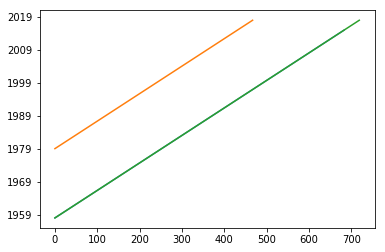

In [88]:
plt.plot(member_dsets[0].time.values)
plt.plot(member_dsets[2].time.values)
plt.plot(all_vars[0].time.values)

In [87]:
all_dsetsd

KeyError: 0

In [78]:
dict(dsb.dims)

{'axis_nbounds': 2,
 'bnds': 2,
 'klevp1': 80,
 'lat': 143,
 'lon': 144,
 'presnivs': 79,
 'time': 432}

In [48]:
concat_dim = xr.DataArray(member_ids, dims='member_id', name='member_id')
ds = xr.concat(member_dsets, dim=concat_dim)

In [60]:
member_dsets_aligned[2]

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, bnds: 2, klevp1: 80, lat: 143, lon: 144, presnivs: 79, time: 432)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat          (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
    ap           (klevp1) float64 0.0 80.59 170.5 270.8 ... 7.627 2.967 0.0
    b            (klevp1) float64 1.0 0.9968 0.9932 0.9892 ... 0.0 0.0 0.0 0.0
    b_bnds       (bnds, klevp1) float64 1.0 0.9984 0.995 0.9912 ... 0.0 0.0 0.0
    ap_bnds      (bnds, klevp1) float64 0.0 40.29 125.5 ... 5.297 1.483 0.0
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<shape=(432, 2), chunksize=(12, 2)>
    ps           (time, l

In [72]:
ds = xr.concat(objs_to_concat, dim=concat_dim, coords='minimal')
ds

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, bnds: 2, klevp1: 80, lat: 143, lon: 144, member_id: 8, presnivs: 79, time: 432)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat          (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
    ap           (klevp1) float64 0.0 80.59 170.5 270.8 ... 7.627 2.967 0.0
    b            (klevp1) float64 1.0 0.9968 0.9932 0.9892 ... 0.0 0.0 0.0 0.0
    b_bnds       (bnds, klevp1) float64 1.0 0.9984 0.995 0.9912 ... 0.0 0.0 0.0
    ap_bnds      (bnds, klevp1) float64 0.0 40.29 125.5 ... 5.297 1.483 0.0
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<shape=(432, 2), chunksize=(12, 2)>
    ps     

In [68]:
objs_to_concat

[<xarray.Dataset>
 Dimensions:      (axis_nbounds: 2, bnds: 2, klevp1: 80, lat: 143, lon: 144, presnivs: 79, time: 432)
 Coordinates:
   * time         (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
   * lat          (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
   * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
   * presnivs     (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
   * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
   * bnds         (bnds) float32 1.0 2.0
     ap           (klevp1) float64 0.0 80.59 170.5 270.8 ... 7.627 2.967 0.0
     b            (klevp1) float64 1.0 0.9968 0.9932 0.9892 ... 0.0 0.0 0.0 0.0
     b_bnds       (bnds, klevp1) float64 1.0 0.9984 0.995 0.9912 ... 0.0 0.0 0.0
     ap_bnds      (bnds, klevp1) float64 0.0 40.29 125.5 ... 5.297 1.483 0.0
     time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<shape=(432, 2), chunksize=(12, 2)>
     ps    

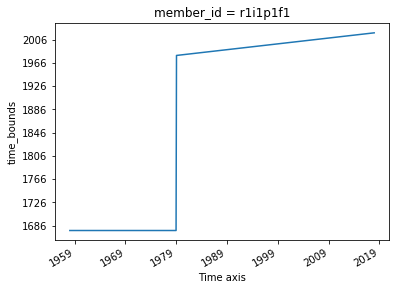

In [53]:
%matplotlib inline
dset.time_bounds.sel(member_id='r1i1p1f1')[:, 0].plot()

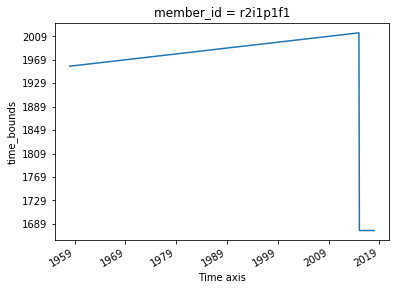

In [54]:
dset.time_bounds.sel(member_id='r2i1p1f1')[:, 0].plot()

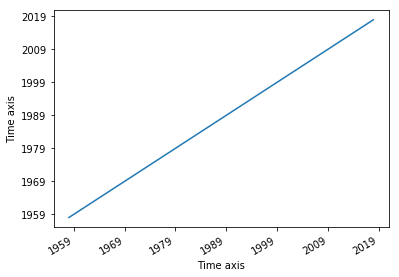

In [55]:
dset.time.plot()

In [14]:
ds1, ds2 = all_vars[-2:]

In [28]:
all_vars[0].attrs['variable_id']

'ccb'

In [34]:
dsm = xr.Dataset()
for ds in all_vars:
    print(ds.attrs['variable_id'])
    dsm = merge_vars(dsm, ds)

ccb
cct
cfc11global
ch4global
ci
cl
cli
clivi
clt
clw
co2mass
evspsbl
hfls
hfss
hur
hurs
hus
mc
n2oglobal
o3
pfull
phalf
pr
prc
prsn
prw
ps
psl
rlds
rldscs
rlus
rlut
rlutcs
rsdscs
rsdt
rsus
rsuscs
rsut
rsutcs
rtmt
sci
sfcWind
ta
tas
tasmax
tasmin
tauu
tauv
ts
ua
uas
va
vas
wap


In [35]:
from functools import reduce
dsm = reduce(merge_vars, all_vars)
dsm

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, bnds: 2, klev: 79, klevp1: 80, lat: 143, lon: 144, plev: 19, presnivs: 79, time: 1800)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
  * lat                 (lat) float32 -90.0 -88.7324 -87.4648 ... 88.7324 90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    time_bounds         (time, axis_nbounds) datetime64[ns] dask.array<shape=(1800, 2), chunksize=(12, 2)>
    climatology_bounds  (time, axis_nbounds) float64 dask.array<shape=(1800, 2), chunksize=(1800, 2)>
  * presnivs            (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1              (klevp1) float64 1.0 2.0 3.0 4.0 ... 77.0 78.0 79.0 80.0
  * bnds                (bnds) float32 1.0 2.0
    ap                  (klevp1) float64 0.0 80.59 170.5 ... 7.627 2.967 0.0
    b                   (klevp1) float64 1.0 0.9968 0.9932 ... 0.0 0.0 0.0
    b_bnds              (bn

In [24]:
dsm

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, bnds: 2, klevp1: 80, lat: 143, lon: 144, presnivs: 79, time: 1800)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
  * lat                 (lat) float32 -90.0 -88.7324 -87.4648 ... 88.7324 90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    time_bounds         (time, axis_nbounds) datetime64[ns] dask.array<shape=(1800, 2), chunksize=(12, 2)>
    climatology_bounds  (time, axis_nbounds) float64 dask.array<shape=(1800, 2), chunksize=(1800, 2)>
  * presnivs            (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1              (klevp1) float64 1.0 2.0 3.0 4.0 ... 77.0 78.0 79.0 80.0
  * bnds                (bnds) float32 1.0 2.0
    ap                  (klevp1) float64 0.0 80.59 170.5 ... 7.627 2.967 0.0
    b                   (klevp1) float64 1.0 0.9968 0.9932 ... 0.0 0.0 0.0
    b_bnds              (bnds, klevp1) float64 

In [16]:
ds2

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, bnds: 2, klevp1: 80, lat: 143, lon: 144, presnivs: 79, time: 1800)
Coordinates:
  * lat          (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
    ap           (klevp1) float64 0.0 80.59 170.5 270.8 ... 7.627 2.967 0.0
    b            (klevp1) float64 1.0 0.9968 0.9932 0.9892 ... 0.0 0.0 0.0 0.0
    b_bnds       (bnds, klevp1) float64 1.0 0.9984 0.995 0.9912 ... 0.0 0.0 0.0
    ap_bnds      (bnds, klevp1) float64 0.0 40.29 125.5 ... 5.297 1.483 0.0
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<shape=(1800, 2), chunksize=(12, 2)>
    ps           (time,

In [17]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:61773 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [21]:
merge_vars(all_vars[2], ds2)

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, bnds: 2, klevp1: 80, lat: 143, lon: 144, presnivs: 79, time: 1800)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<shape=(1800, 2), chunksize=(12, 2)>
  * lat          (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
    ap           (klevp1) float64 0.0 80.59 170.5 270.8 ... 7.627 2.967 0.0
    b            (klevp1) float64 1.0 0.9968 0.9932 0.9892 ... 0.0 0.0 0.0 0.0
    b_bnds       (bnds, klevp1) float64 1.0 0.9984 0.995 0.9912 ... 0.0 0.0 0.0
    ap_bnds      (bnds, klevp1) float64 0.0 40.29 125.5 ... 5.297 1.483 0.0
    ps           (time,

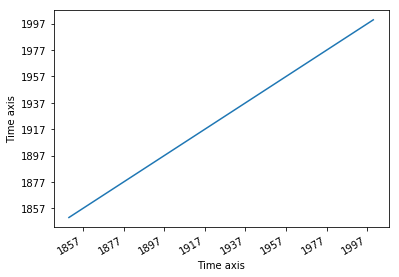

In [215]:
%matplotlib inline
ds1.time.plot()

In [219]:
url = m_files.OPENDAP_url.values[0]
print(url)
ds1 = xr.open_dataset(url, decode_cf=False)
ds1

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1pctCO2/r1i1p1f1/Amon/cl/gr/v20180727/cl_Amon_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gr_185001-199912.nc


<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, bnds: 2, klevp1: 80, lat: 143, lon: 144, presnivs: 79, time: 1800)
Coordinates:
  * lat          (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
  * time         (time) float64 15.5 45.0 74.5 ... 5.471e+04 5.474e+04 5.477e+04
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) float64 ...
    ap           (klevp1) float64 ...
    b            (klevp1) float64 ...
    cl           (time, presnivs, lat, lon) float32 ...
    ps           (time, lat, lon) float32 ...
    b_bnds       (bnds, klevp1) float64 ...
    ap_bnds      (bnds, klevp1) float64 ...
Attributes:
    name:                            /ccc/work/

In [223]:
ds1.presnivs

<xarray.DataArray 'presnivs' (presnivs: 79)>
array([  1.012021e+05,   1.009424e+05,   1.006534e+05,   1.003319e+05,
         9.997420e+04,   9.957655e+04,   9.913467e+04,   9.864384e+04,
         9.809898e+04,   9.749448e+04,   9.682430e+04,   9.608191e+04,
         9.526024e+04,   9.435173e+04,   9.334834e+04,   9.224155e+04,
         9.102246e+04,   8.968182e+04,   8.821020e+04,   8.659811e+04,
         8.483623e+04,   8.291569e+04,   8.082840e+04,   7.856748e+04,
         7.612779e+04,   7.350645e+04,   7.070354e+04,   6.772281e+04,
         6.457239e+04,   6.126538e+04,   5.782047e+04,   5.426217e+04,
         5.062074e+04,   4.693169e+04,   4.323469e+04,   3.957199e+04,
         3.598637e+04,   3.251885e+04,   2.920636e+04,   2.607983e+04,
         2.316271e+04,   2.047042e+04,   1.801036e+04,   1.578271e+04,
         1.378158e+04,   1.199642e+04,   1.041344e+04,   9.016865e+03,
         7.790020e+03,   6.716147e+03,   5.778999e+03,   4.963233e+03,
         4.254644e+03,   3.64027

In [222]:
ds1.ap

<xarray.DataArray 'ap' (klevp1: 80)>
array([  0.000000e+00,   8.058910e+01,   1.704975e+02,   2.707961e+02,
         3.826760e+02,   5.074617e+02,   6.466239e+02,   8.017942e+02,
         9.747804e+02,   1.167582e+03,   1.382404e+03,   1.621677e+03,
         1.888064e+03,   2.184476e+03,   2.514080e+03,   2.880294e+03,
         3.286784e+03,   3.737439e+03,   4.236330e+03,   4.787648e+03,
         5.395609e+03,   6.064310e+03,   6.797553e+03,   7.598588e+03,
         8.469793e+03,   9.412274e+03,   1.042537e+04,   1.150608e+04,
         1.264839e+04,   1.384256e+04,   1.507443e+04,   1.632462e+04,
         1.756801e+04,   1.877316e+04,   1.990195e+04,   2.090921e+04,
         2.174209e+04,   2.233877e+04,   2.262588e+04,   2.251484e+04,
         2.190151e+04,   2.069138e+04,   1.890311e+04,   1.679887e+04,
         1.472388e+04,   1.283650e+04,   1.115627e+04,   9.670609e+03,
         8.363122e+03,   7.216918e+03,   6.215375e+03,   5.342622e+03,
         4.583844e+03,   3.925444e+03,  

In [218]:
ds_cl = all_vars[5]
ds_cl.cl

<xarray.DataArray 'cl' (time: 1800, presnivs: 79, lat: 143, lon: 144)>
dask.array<shape=(1800, 79, 143, 144), dtype=float32, chunksize=(12, 79, 143, 144)>
Coordinates:
  * lat       (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
  * lon       (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs  (presnivs) float32 101202.0 100942.0 100653.0 ... 5.2968 1.48343
  * time      (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
Attributes:
    long_name:           Cloud Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       cloud_area_fraction_in_atmosphere_layer
    description:         Includes both large-scale and convective cloud.
    history:             none
    cell_measures:       area: areacella
    _ChunkSizes:         [  1  79 143 144]

In [201]:
dsm = xr.merge(all_vars[:5])
dsm

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, lat: 143, lon: 144, time: 1800)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
  * lat                 (lat) float32 -90.0 -88.7324 -87.4648 ... 88.7324 90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    time_bounds         (time, axis_nbounds) datetime64[ns] dask.array<shape=(1800, 2), chunksize=(12, 2)>
    climatology_bounds  (time, axis_nbounds) float64 dask.array<shape=(1800, 2), chunksize=(1800, 2)>
Dimensions without coordinates: axis_nbounds
Data variables:
    ccb                 (time, lat, lon) float32 dask.array<shape=(1800, 143, 144), chunksize=(12, 143, 144)>
    cct                 (time, lat, lon) float32 dask.array<shape=(1800, 143, 144), chunksize=(12, 143, 144)>
    cfc11global         (time) float32 dask.array<shape=(1800,), chunksize=(12,)>
    ch4global           (time) float32 dask.array<shape=(1800,), chunksize=(180

In [209]:
for d in all_vars[:7]:
    for v in d.data_vars:
        print(v, d[v].attrs.get('standard_name'))

ccb air_pressure_at_convective_cloud_base
cct air_pressure_at_convective_cloud_top
cfc11global None
ch4global None
ci convection_time_fraction
ap None
b None
cl cloud_area_fraction_in_atmosphere_layer
ps surface_air_pressure
ap None
b None
cli mass_fraction_of_cloud_ice_in_air
ps surface_air_pressure


In [ ]:
xr.merge()

In [55]:
merge_vars(all_vars)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 160, lon: 320, member_id: 1, plev: 19, time: 3624)
Coordinates:
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
    lat_bnds   (lat, bnds) float64 -90.0 -88.59 -88.59 ... 88.59 88.59 90.0
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
    lon_bnds   (lon, bnds) float64 -0.5625 0.5625 0.5625 ... 358.3 358.3 359.4
  * time       (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
    time_bnds  (time, bnds) object 1850-01-01 00:00:00 ... 2001-01-01 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    ta         (member_id, time, plev, lat, lon) float32 dask.array<shape=(1, 3624, 19, 160, 320), chunksize=(1, 12, 19, 160, 320)>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch

In [177]:
ds1, ds2 = all_vars[:2]

In [188]:
xr.merge(all_vars[:5])

<xarray.Dataset>
Dimensions:             (axis_nbounds: 2, lat: 143, lon: 144, time: 1800)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
  * lat                 (lat) float32 -90.0 -88.7324 -87.4648 ... 88.7324 90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    time_bounds         (time, axis_nbounds) datetime64[ns] dask.array<shape=(1800, 2), chunksize=(12, 2)>
    climatology_bounds  (time, axis_nbounds) float64 dask.array<shape=(1800, 2), chunksize=(1800, 2)>
Dimensions without coordinates: axis_nbounds
Data variables:
    ccb                 (time, lat, lon) float32 dask.array<shape=(1800, 143, 144), chunksize=(12, 143, 144)>
    cct                 (time, lat, lon) float32 dask.array<shape=(1800, 143, 144), chunksize=(12, 143, 144)>
    cfc11global         (time) float32 dask.array<shape=(1800,), chunksize=(12,)>
    ch4global           (time) float32 dask.array<shape=(1800,), chunksize=(180

In [191]:
ds_ps = all_vars[5]
ds_ps

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, bnds: 2, klevp1: 80, lat: 143, lon: 144, presnivs: 79, time: 1800)
Coordinates:
  * lat          (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 101202.0 100942.0 ... 5.2968 1.48343
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
    b_bnds       (bnds, klevp1) float64 1.0 0.9984 0.995 0.9912 ... 0.0 0.0 0.0
    ap_bnds      (bnds, klevp1) float64 0.0 40.29 125.5 ... 5.297 1.483 0.0
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<shape=(1800, 2), chunksize=(12, 2)>
Dimensions without coordinates: axis_nbounds
Data variables:
    ap           (time, klevp1) float64 dask.array<shape=(1800, 80), chunksize=(1800, 80)>
    b            (time, kl

In [200]:
ds_ps.ps

<xarray.DataArray 'ps' (time: 1800, lat: 143, lon: 144)>
dask.array<shape=(1800, 143, 144), dtype=float32, chunksize=(12, 143, 144)>
Coordinates:
  * lat      (lat) float32 -90.0 -88.7324 -87.4648 ... 87.4648 88.7324 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
Attributes:
    long_name:           Surface Air Pressure
    units:               Pa
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_air_pressure
    description:         not, in general, the same as mean sea-level pressure
    history:             none
    cell_measures:       area: areacella
    _ChunkSizes:         [  1 143 144]

In [44]:

all_dsets[tuple('BCC.BCC-CSM2-MR.historical.Amon.gn'.split('.'))]

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 160, lon: 320, member_id: 3, plev: 19, time: 1980)
Coordinates:
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
    lat_bnds   (lat, bnds) float64 -90.0 -88.59 -88.59 ... 88.59 88.59 90.0
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
    lon_bnds   (lon, bnds) float64 -0.5625 0.5625 0.5625 ... 358.3 358.3 359.4
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    ta         (member_id, time, plev, lat, lon) float32 dask.array<shape=(3, 1980, 19, 160, 320), chunksize=(1, 12, 19, 160, 320)>

In [45]:
all_vars

[]

In [ ]:
xr.concat()

In [40]:
for k, f in v.groupby(['member_id', 'variable_id']):
    print(k, len(f))

('r1i1p1f1', 'ta') 300


In [383]:
def recursive_groupby(df, by):
    if isinstance(by, str):
        for k, v in df.groupby(by):
            yield k, v

for k, v in recursive_groupby(files, 'mip_era'):
    print(k)

CMIP6


In [389]:
for k0, v0 in files.groupby(required_fields[0]):
    print(len(v))
    for k1, v1 in v0.groupby(required_fields[1]):
        print(len(v1))
        for k2, v2 in v1.groupby(required_fields[2]):
            print(len(v2))
            print(dict(zip(required_fields[:3], [k0, k1, k2])))

153
153
9
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'BCC'}
19
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'CNRM-CERFACS'}
7
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'IPSL'}
84
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'MIROC'}
34
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'NASA-GISS'}


In [385]:
v2

,dataset_id,id,version,activity_drs,activity_id,branch_method,cf_standard_name,checksum,checksum_type,citation_url,...,variable,variable_id,variable_long_name,variable_units,variant_label,_version_,retracted,_timestamp,score,OPENDAP_url
119,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,1,CMIP,CMIP,standard,air_temperature,dc83b52e9b5f1087bbde4c69cd05590603bf311e4fa61a...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623059987626459136,False,2019-01-19T04:03:44.186Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
120,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,1,CMIP,CMIP,standard,air_temperature,4711be106b584d2022c8f04e395de3925891cbbce13120...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623059987597099008,False,2019-01-19T04:03:44.158Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
121,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,1,CMIP,CMIP,standard,air_temperature,43203f990b71357c35c417752f6f7cbb01713e790a9887...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623059987567738880,False,2019-01-19T04:03:44.130Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
122,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,1,CMIP,CMIP,standard,air_temperature,f17a9fa4ba702689adae96233bf5512bbd6e65a1f5c45d...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623060827810562048,False,2019-01-19T04:17:05.448Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
123,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,1,CMIP,CMIP,standard,air_temperature,3d977fc292951a137426665818435cfae0c76ec15fd2db...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623060827783299072,False,2019-01-19T04:17:05.422Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
124,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,1,CMIP,CMIP,standard,air_temperature,eef0b936361a2b37765871fe9e051cd9c2776c1516b578...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623060827754987520,False,2019-01-19T04:17:05.395Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
125,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,1,CMIP,CMIP,standard,air_temperature,b71980be0c790d242788702fb33187af4618d093c2718c...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623072931392258048,False,2019-01-19T07:29:28.323Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
126,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,1,CMIP,CMIP,standard,air_temperature,6f33061de83e740b3db96caaef67c0b2b6ac25249e7e77...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623072931364995072,False,2019-01-19T07:29:28.297Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
127,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,1,CMIP,CMIP,standard,air_temperature,35425874c951574b5f815a19b1924f6f254b03d30831fd...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623072931336683520,False,2019-01-19T07:29:28.270Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
128,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,1,CMIP,CMIP,st

In [317]:
variable = files['variable']
data_node = files['data_node'] 

In [323]:
isinstance(variable, str)

False

In [309]:
vd = v.drop('url', axis=1)
vd

,dataset_id,id,mip_era,activity_drs,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label
149,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn
150,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn
151,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn
152,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn


In [406]:
for k, v in files.groupby('dataset_id'):
    print(k)

CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1.Amon.ta.gn.v20181126|cmip.bcc.cma.cn
CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r2i1p1f1.Amon.ta.gn.v20181115|cmip.bcc.cma.cn
CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r3i1p1f1.Amon.ta.gn.v20181119|cmip.bcc.cma.cn
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.AERmonZ.ta.grz.v20180917|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Amon.ta.gr.v20180917|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.CFmon.ta.gr.v20180917|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r2i1p1f2.AERmonZ.ta.grz.v20181126|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r2i1p1f2.Amon.ta.gr.v20181126|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r2i1p1f2.CFmon.ta.gr.v20181126|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r10i1p1f1.Amon.ta.gn.v20180830|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Amon.ta.gn.v20180827|aims3.llnl.gov


,dataset_id,id,version,activity_drs,activity_id,branch_method,cf_standard_name,checksum,checksum_type,citation_url,...,variable,variable_id,variable_long_name,variable_units,variant_label,_version_,retracted,_timestamp,score,url
149,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,040fcbcc7beb2a149413d434ea8d0d55280d2d274f0a64...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085480053571584,False,2019-01-19T10:48:55.659Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
150,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,787f3551c8f1dbb4fccfc46361bed7b11f64f5f38ffcb8...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085480007434240,False,2019-01-19T10:48:55.615Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
151,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,0bf8732e197e8061152030de3327c74d5a204be3b4054c...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085479982268416,False,2019-01-19T10:48:55.590Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
152,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,aee8a941fbbc2e138287ac7f8276d82d0a65136e11371a...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085479925645312,False,2019-01-19T10:48:55.537Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...


In [345]:
set(v.columns)

{'_timestamp',
 '_version_',
 'activity_drs',
 'activity_id',
 'branch_method',
 'cf_standard_name',
 'checksum',
 'checksum_type',
 'citation_url',
 'data_node',
 'data_specs_version',
 'dataset_id',
 'dataset_id_template_',
 'directory_format_template_',
 'experiment_id',
 'experiment_title',
 'frequency',
 'further_info_url',
 'grid',
 'grid_label',
 'id',
 'index_node',
 'instance_id',
 'institution_id',
 'latest',
 'master_id',
 'member_id',
 'mip_era',
 'model_cohort',
 'nominal_resolution',
 'pid',
 'product',
 'project',
 'realm',
 'replica',
 'retracted',
 'score',
 'size',
 'source_id',
 'source_type',
 'sub_experiment_id',
 'table_id',
 'timestamp',
 'title',
 'tracking_id',
 'type',
 'url',
 'variable',
 'variable_id',
 'variable_long_name',
 'variable_units',
 'variant_label',
 'version'}

In [346]:
non_duplicate_columns = {'checksum', 'id'}
all_columns = set(v.columns)
subset = all_columns - non_duplicate_columns
v.drop_duplicates(subset=subset)

,dataset_id,id,version,activity_drs,activity_id,branch_method,cf_standard_name,checksum,checksum_type,citation_url,...,variable,variable_id,variable_long_name,variable_units,variant_label,_version_,retracted,_timestamp,score,url
149,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,040fcbcc7beb2a149413d434ea8d0d55280d2d274f0a64...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085480053571584,False,2019-01-19T10:48:55.659Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
150,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,787f3551c8f1dbb4fccfc46361bed7b11f64f5f38ffcb8...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085480007434240,False,2019-01-19T10:48:55.615Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
151,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,0bf8732e197e8061152030de3327c74d5a204be3b4054c...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085479982268416,False,2019-01-19T10:48:55.590Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
152,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,aee8a941fbbc2e138287ac7f8276d82d0a65136e11371a...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085479925645312,False,2019-01-19T10:48:55.537Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...


In [366]:
dict(v[v.columns[v.nunique() == 1]].iloc[0])

{'dataset_id': 'CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Amon.tas.gn.v20180827|aims3.llnl.gov',
 'version': '1',
 'activity_drs': 'CMIP',
 'activity_id': 'CMIP',
 'branch_method': 'standard',
 'cf_standard_name': 'air_temperature',
 'checksum_type': 'SHA256',
 'citation_url': 'http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Amon.tas.gn.v20180827.json',
 'data_node': 'aims3.llnl.gov',
 'data_specs_version': '01.00.23',
 'dataset_id_template_': '%(mip_era)s.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s',
 'directory_format_template_': '%(root)s/%(mip_era)s/%(activity_drs)s/%(institution_id)s/%(source_id)s/%(experiment_id)s/%(member_id)s/%(table_id)s/%(variable_id)s/%(grid_label)s/%(version)s',
 'experiment_id': 'historical',
 'experiment_title': 'all-forcing simulation of the recent past',
 'frequency': 'mon',
 'further_info_url': 'https://furtherinfo.e

In [355]:
unique_counts = v.nunique() == 1
unique_counts

dataset_id                     True
id                            False
version                        True
activity_drs                   True
activity_id                    True
branch_method                  True
cf_standard_name               True
checksum                      False
checksum_type                  True
citation_url                   True
data_node                      True
data_specs_version             True
dataset_id_template_           True
directory_format_template_     True
experiment_id                  True
experiment_title               True
frequency                      True
further_info_url               True
grid                           True
grid_label                     True
index_node                     True
instance_id                   False
institution_id                 True
latest                         True
master_id                     False
member_id                      True
mip_era                        True
model_cohort                

In [400]:
dsets = {}
for k, v in files.groupby('dataset_id'):
    if 'aims3.llnl.gov' in k:
        print(k)
        dsets[k] = xr.open_mfdataset(sorted(list(v.OPENDAP_url)), chunks={'time': 12})

CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.1pctCO2.r1i1p1f2.Amon.ta.gr.v20180626|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.1pctCO2.r1i1p1f2.CFmon.ta.gr.v20180626|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r1i1p1f2.Amon.ta.gr.v20180705|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r1i1p1f2.CFmon.ta.gr.v20180705|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r2i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r3i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r4i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r5i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r6i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1f2.AERmonZ.ta.grz.v20181203|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1f2.Amon.ta.gr.v20181203|aims3.llnl.g

KeyboardInterrupt: 

In [304]:
ds = dsets['CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r5i1p1f1.Amon.tas.gn.v20181016|aims3.llnl.gov']
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lon: 144, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
    height     float64 2.0
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(1980, 2), chunksize=(12, 2)>
    lat_bnds   (time, lat, bnds) float64 dask.array<shape=(1980, 90, 2), chunksize=(612, 90, 2)>
    lon_bnds   (time, lon, bnds) float64 dask.array<shape=(1980, 144, 2), chunksize=(612, 144, 2)>
    tas        (time, lat, lon) float32 dask.array<shape=(1980, 90, 144), chunksize=(12, 90, 144)>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:         

In [306]:
ds.tas.nbytes / 1e6

102.6432

In [ ]:
#             dataset_labels = [label for label in
#                               re.split('%\(|\)s\.*', template) if len(label)>0]
#             # only keep the values that are described in the template
#             # that usually means discarding version, which is not in the template
#             dataset_values = dataset_id.split('.')[:len(dataset_labels)]
#             item = OrderedDict(dataset_id=dataset_id, id=d['id'])
#             #item.update(zip(dataset_labels, dataset_values))


Some of the json metadata that comes with the request:

    "dataset_id":"CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov",
    "dataset_id_template_":["%(mip_era)s.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s"],

In [64]:
d.update?

Docstring:
D.update([E, ]**F) -> None.  Update D from dict/iterable E and F.
If E is present and has a .keys() method, then does:  for k in E: D[k] = E[k]
If E is present and lacks a .keys() method, then does:  for k, v in E: D[k] = v
In either case, this is followed by: for k in F:  D[k] = F[k]
Type:      builtin_function_or_method


In [141]:
from string import Template

class ESGFTemplate(Template):
    delimiter = r'%'
t = ESGFTemplate(test_str)
t.delimiter

'%'

In [151]:
#tem = ESGFTemplate('foo %{bar}')
tem = ESGFTemplate('%{mip_era}s')
tem.substitute(mip_era='cool')

'cools'

In [154]:
fixes = {'\(': '{', '\)': '}', '%': '$'}
test_str_fixed = test_str
for pattern, repl in fixes.items():
    test_str_fixed = re.sub(pattern, repl, test_str_fixed)
test_str_fixed

'${mip_era}s.${activity_drs}s.${institution_id}s.${source_id}s.${experiment_id}s.${member_id}s.${table_id}s.${variable_id}s.${grid_label}s'

In [195]:
from string import Template
import re

def dataset_params(dataset_id, dataset_id_template):
    template_pattern = dataset_id_template
    fixes = {'\(': '{', '\)': '}', '%': '$'}
    for pattern, repl in fixes.items():
        template_pattern = re.sub(template_pattern, repl, test_str_fixed)
    template = Template(template_pattern)
    return template.pattern.findall(template_pattern)
    #return template_pattern, template

In [198]:
dataset_params(files.loc[0].dataset_id, other_test_str)


[('', '', 'mip_era', ''),
 ('', '', 'activity_drs', ''),
 ('', '', 'institution_id', ''),
 ('', '', 'source_id', ''),
 ('', '', 'experiment_id', ''),
 ('', '', 'member_id', ''),
 ('', '', 'table_id', ''),
 ('', '', 'variable_id', ''),
 ('', '', 'grid_label', '')]

In [189]:
pat

'${mip_era}s.${activity_drs}s.${institution_id}s.${source_id}s.${experiment_id}s.${member_id}s.${table_id}s.${variable_id}s.${grid_label}s'

In [183]:
repat = tem.pattern
repat

re.compile(r'\n    \$(?:\n      (?P<escaped>\$) |   # Escape sequence of two delimiters\n      (?P<named>(?-i:[_a-zA-Z][_a-zA-Z0-9]*))      |   # delimiter and a Python identifier\n      {(?P<braced>(?-i:[_a-zA-Z][_a-zA-Z0-9]*))}   |   # delimiter and a braced identifier\n      (?P<invalid>)              # Other ill-formed delimiter exprs\n    )\n    ',
re.IGNORECASE|re.UNICODE|re.VERBOSE)

In [202]:
repat.search(pat).group('braced')

'mip_era'

In [224]:
match.group()

'${grid_label}'

In [ ]:
repat.sub()

In [203]:
for match in repat.finditer(pat):
    print(match.group('braced'))

mip_era
activity_drs
institution_id
source_id
experiment_id
member_id
table_id
variable_id
grid_label


In [162]:
pat = tem.pattern



    \$(?:
      (?P<escaped>\$) |   # Escape sequence of two delimiters
      (?P<named>(?-i:[_a-zA-Z][_a-zA-Z0-9]*))      |   # delimiter and a Python identifier
      {(?P<braced>(?-i:[_a-zA-Z][_a-zA-Z0-9]*))}   |   # delimiter and a braced identifier
      (?P<invalid>)              # Other ill-formed delimiter exprs
    )
    


In [127]:
import re
test_str = "%(mip_era)s.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s"
other_test_str = "CMIP6.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s"
#labels = [label for label in re.split('%\(|\)s\.*', other_test_str) if len(label)>0]
labels = 

labels




['CMIP6.',
 'activity_drs',
 'institution_id',
 'source_id',
 'experiment_id',
 'member_id',
 'table_id',
 'variable_id',
 'grid_label']

In [250]:
files.grid_label.unique()

array(['gn', 'gr'], dtype=object)

In [254]:
files = esgf_search(experiment_id="amip", frequency="mon")#, institution_id="NASA-GISS")
files

https://esgf-node.llnl.gov/esg-search/search/?experiment_id=amip&frequency=mon&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0


,dataset_id,id,mip_era,activity_drs,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,url
0,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,abs550aer,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
1,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,airmass,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
2,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,cdnc,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
3,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,cltc,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
4,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,cod,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
5,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,lwp,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
6,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,o3,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
7,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,od550aer,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
8,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,od550bc,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...


In [176]:
n=0
print(files.loc[n].dataset_id)
print(files.loc[n].id)
files.loc[n]

CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016.cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_185001-190012.nc|aims3.llnl.gov


dataset_id        CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1...
id                CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1...
mip_era                                                       CMIP6
activity_drs                                                   CMIP
institution_id                                            NASA-GISS
source_id                                               GISS-E2-1-G
experiment_id                                                  amip
member_id                                                  r2i1p1f1
table_id                                                       Amon
variable_id                                                      cl
grid_label                                                       gn
url               http://aims3.llnl.gov/thredds/dodsC/css03_data...
Name: 0, dtype: object

In [177]:
n=4
print(files.loc[n].dataset_id)
print(files.loc[n].id)
files.loc[n]

CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016.cl_Amon_amip_GISS-E2-1-G_r2i1p1f1_gn_185001-190012.nc|aims3.llnl.gov


dataset_id        CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1...
id                CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1...
mip_era                                                       CMIP6
activity_drs                                                   CMIP
institution_id                                            NASA-GISS
source_id                                               GISS-E2-1-G
experiment_id                                                  amip
member_id                                                  r2i1p1f1
table_id                                                       Amon
variable_id                                                      cl
grid_label                                                       gn
url               http://aims3.llnl.gov/thredds/dodsC/css03_data...
Name: 4, dtype: object

In [106]:
gb = files.groupby('dataset_id')
for k, v in gb:
    print(k)

CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov


In [107]:
urls = sorted(list(v['url'].values))
urls

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_185001-190012.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_190101-195012.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_195101-200012.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_200101-201412.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_amip_GISS-E2-1-G_r2i1p1f1_gn_185001-190012.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20

In [108]:
print(urls[0])
print(urls[-2])

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_185001-190012.nc.html
http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_amip_GISS-E2-1-G_r2i1p1f1_gn_185001-190012.nc.html


In [109]:
ds1 = xr.open_dataset(urls[0][:-5]).chunk({'time': 12})
ds1 

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 612)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(612, 2), chunksize=(12, 2)>
    lev_bnds   (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    p0         float64 ...
    a          (lev) float64 dask.array<shape=(29,), chunksize=(29,)>
    b          (lev) float64 dask.array<shape=(29,), chunksize=(29,)>
    a_bnds     (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    b_bnds     (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    lat_bnds   (lat, bnds) float64 dask.array<shape=(90, 2)

In [110]:
ds2 = xr.open_dataset(urls[-2][:-5]).chunk({'time': 12})
ds2 

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 612)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(612, 2), chunksize=(12, 2)>
    lev_bnds   (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    p0         float64 ...
    a          (lev) float64 dask.array<shape=(29,), chunksize=(29,)>
    b          (lev) float64 dask.array<shape=(29,), chunksize=(29,)>
    a_bnds     (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    b_bnds     (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    lat_bnds   (lat, bnds) float64 dask.array<shape=(90, 2)

In [111]:
ds1.load()

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 612)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 0.0 31.0 31.0 ... 1.858e+04 1.862e+04
    lev_bnds   (lev, bnds) float64 0.96 0.94 0.94 0.92 ... 0.42 0.4 0.4 0.38
    p0         float64 1.0
    a          (lev) float64 0.734 0.9224 1.13 ... 4.814e+03 4.913e+03 4.557e+03
    b          (lev) float64 1.0 0.9797 0.9573 ... 0.03867 0.02031 0.007954
    a_bnds     (lev, bnds) float64 0.734 0.8282 0.8282 ... 4.735e+03 4.167e+03
    b_bnds     (lev, bnds) float64 1.0 0.9898 0.9898 ... 0.01413 0.005114
    lat_bnds   (lat, bnds) float64 -90.0 -88.0 -88.0 -86.0 .

In [112]:
ds2.load()

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 612)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 0.0 31.0 31.0 ... 1.858e+04 1.862e+04
    lev_bnds   (lev, bnds) float64 0.96 0.94 0.94 0.92 ... 0.42 0.4 0.4 0.38
    p0         float64 1.0
    a          (lev) float64 0.734 0.9224 1.13 ... 4.814e+03 4.913e+03 4.557e+03
    b          (lev) float64 1.0 0.9797 0.9573 ... 0.03867 0.02031 0.007954
    a_bnds     (lev, bnds) float64 0.734 0.8282 0.8282 ... 4.735e+03 4.167e+03
    b_bnds     (lev, bnds) float64 1.0 0.9898 0.9898 ... 0.01413 0.005114
    lat_bnds   (lat, bnds) float64 -90.0 -88.0 -88.0 -86.0 .

In [113]:
ds1.equals(ds2)

True

In [10]:
ds = xr.open_mfdataset(files[:4])
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 1980)
Coordinates:
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(1980, 2), chunksize=(612, 2)>
    lev_bnds   (time, lev, bnds) float64 dask.array<shape=(1980, 29, 2), chunksize=(612, 29, 2)>
    p0         (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    a          (time, lev) float64 dask.array<shape=(1980, 29), chunksize=(612, 29)>
    b          (time, lev) float64 dask.array<shape=(1980, 29), chunksize=(612, 29)>
    a_bnds     (time, lev, bnds) float64 dask.array<shape=(1980, 29, 2), chunksize=(612, 29, 2)>
    b_bnds     (time,

In [46]:
ds2 = ds1.set_coords('lev_bnds')
ds2.isel(time=slice(0, 2)).to_netcdf('test.nc', mode='w')

In [40]:
ds3.time.encoding

{'zlib': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/home/jovyan/test.nc',
 'original_shape': (2,),
 'dtype': dtype('float64'),
 '_FillValue': nan,
 'units': 'days since 1850-01-01',
 'calendar': 'gregorian'}

In [47]:
ds3 = xr.open_dataset('test.nc')
ds3

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, bnds: 2, lat: 128, lev: 91, lon: 256, time: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lev          (lev) float64 0.9988 0.9959 0.992 ... 2.951e-05 9.869e-06
    lev_bounds   (lev, axis_nbounds) float64 ...
  * time         (time) datetime64[ns] 1979-01-16T12:00:00 1979-02-15
Dimensions without coordinates: axis_nbounds, bnds
Data variables:
    time_bounds  (time, axis_nbounds) float64 ...
    ap           (lev) float64 ...
    b            (lev) float64 ...
    b_bnds       (bnds, lev) float64 ...
    ap_bnds      (bnds, lev) float64 ...
    cl           (time, lev, lat, lon) float32 ...
    ps           (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-07-11T12:03:52Z
    description:                     DECK: 

In [30]:
ds1.cl

<xarray.DataArray 'cl' (time: 432, lev: 91, lat: 128, lon: 256)>
[1288175616 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lev      (lev) float64 0.9988 0.9959 0.992 ... 5.61e-05 2.951e-05 9.869e-06
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    long_name:           Cloud Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       cloud_area_fraction_in_atmosphere_layer
    description:         Includes both large-scale and convective cloud.
    history:             none
    cell_measures:       area: areacella
    _ChunkSizes:         [  1  91 128 256]

In [9]:
ds = xr.open_mfdataset(files, chunks={'time': 12})
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 1980)
Coordinates:
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(1980, 2), chunksize=(12, 2)>
    lev_bnds   (time, lev, bnds) float64 dask.array<shape=(1980, 29, 2), chunksize=(612, 29, 2)>
    p0         (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    a          (time, lev) float64 dask.array<shape=(1980, 29), chunksize=(612, 29)>
    b          (time, lev) float64 dask.array<shape=(1980, 29), chunksize=(612, 29)>
    a_bnds     (time, lev, bnds) float64 dask.array<shape=(1980, 29, 2), chunksize=(612, 29, 2)>
    b_bnds     (time, 

In [15]:
ds.cl

<xarray.DataArray 'cl' (time: 1980, lev: 29, lat: 90, lon: 144)>
dask.array<shape=(1980, 29, 90, 144), dtype=float32, chunksize=(12, 29, 90, 144)>
Coordinates:
  * lev      (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.47 0.45 0.43 0.41 0.39
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    standard_name:  cloud_area_fraction_in_atmosphere_layer
    long_name:      Cloud Area Fraction
    comment:        Percentage cloud cover, including both large-scale and co...
    units:          %
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

In [10]:
ds_mean = ds.ps.groupby('time.month').mean(dim='time').load()

In [16]:
cl_mean = ds.cl.groupby('time.month').mean(dim=('time', 'lon')).load()

In [17]:
ds.cl.nbytes / 1e9

2.9766528

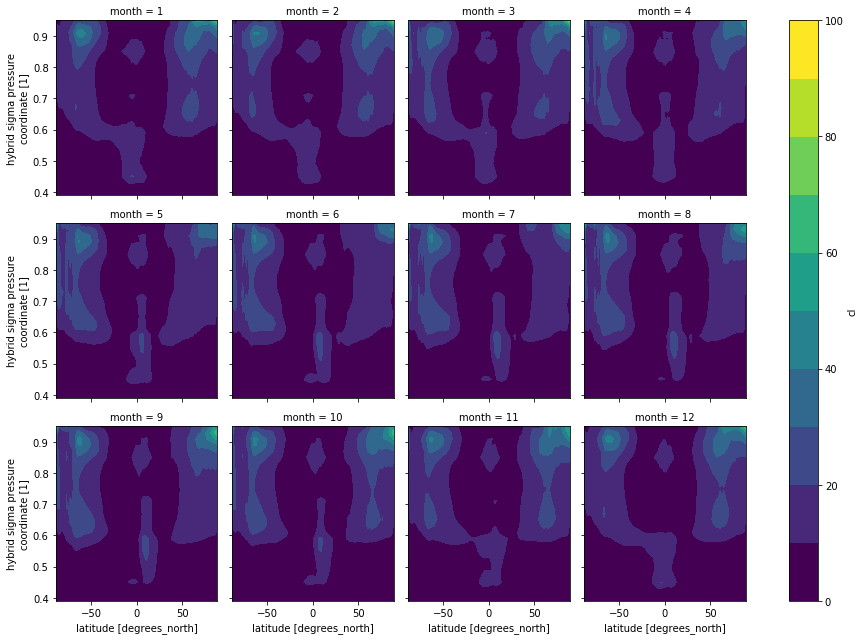

In [26]:
cl_mean.plot.contourf(levels=range(0,101,10), col='month', col_wrap=4)

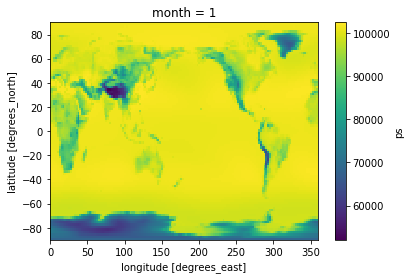

In [12]:
ds_mean[0].plot()

## Set up Dask Cluster

In [97]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=8)
client = Client(cluster)
cluster

## Construct Xarray Dataset by Crawling THREDDS Server

We are using NARR daily pressure-level data.

https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/Dailies/pressure/catalog.html

In [6]:
from siphon.catalog import TDSCatalog
cat_url = 'https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/Dailies/pressure/catalog.xml'
cat = TDSCatalog(cat_url)
dsets = [(cds.remote_access(use_xarray=True)
             .reset_coords(drop=True)
             .chunk({'time': 1, 'level': 5}))
         for cds in cat.datasets[:30]]
narr = xr.auto_combine(dsets)
narr

<xarray.Dataset>
Dimensions:            (level: 29, nbnds: 2, time: 912, x: 349, y: 277)
Coordinates:
  * level              (level) float32 1000.0 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 32463.0 64926.0 ... 8927325.0 8959788.0
  * x                  (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * time               (time) datetime64[ns] 1979-01-01 ... 1981-06-30
Dimensions without coordinates: nbnds
Data variables:
    Lambert_Conformal  (time) int32 -2147483647 -2147483647 ... -2147483647
    time_bnds          (time, nbnds) float64 dask.array<shape=(912, 2), chunksize=(1, 2)>
    air                (time, level, y, x) float32 dask.array<shape=(912, 29, 277, 349), chunksize=(1, 5, 277, 349)>

## Process Data in Parallel

This works amazingly well.

In [7]:
air_mean = narr.air[:100].mean(dim='time').load()

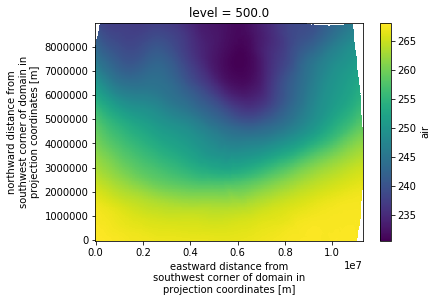

In [9]:
%matplotlib inline
air_mean.sel(level=500).plot()